## Find features in proximity to sensors

Within a radius of each sensor, find:
* the number of features of each type (bike stations, lights, landmarks, furniture, and buildings for each year)
* the number of features of each subtype for landmarks, furniture and buildings  

### Code initialisation

In [1]:
import pandas as pd
import geopandas as gpd
from IPython.display import Image
from shapely.geometry import Point, Polygon
import folium
import numpy as np
from shapely.ops import transform
import pyproj
import os
import contextily as cx
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

from shapely.errors import ShapelyDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

buffer_size_m = 100

### Functions

In [2]:
def create_features_gdf (fp):
    # Read in csv
    feature_df = pd.read_csv(fp)
    # Convert to geodataframe
    feature_gdf = gpd.GeoDataFrame(feature_df, geometry=gpd.points_from_xy(feature_df['Longitude'], feature_df['Latitude']))
    feature_gdf.set_crs(epsg=4326, inplace=True)
    
    return feature_gdf

def draw_buffers(sensors_gdf):
    # Convert CRS of sensor data to one that works with finding the radius
    reprojected_sensors = sensors_gdf.copy()
    reprojected_sensors.to_crs(crs=3577, inplace = True)

    # Draw a buffer around each sensor in metres
    reprojected_sensors['polygon'] = reprojected_sensors.geometry.buffer(buffer_size_m)   

    return reprojected_sensors

# Function which finds which features from a geodataframe of features are within the radius of a sensor
# and saves the location and feature sub-types of these
def find_features_near_sensor (sensor_num, gdf, buffer_size_m, grouping_col_name):
    # Convert CRS of sensor data to one that works with finding the radius
    global buffered_sensors

    # Get geodataframe from just this sensor
    this_sensor_gdf = buffered_sensors[buffered_sensors.sensor_id == sensor_num]
    this_sensor_gdf.reset_index(inplace = True, drop = True)

    # Set up reprojection
    project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:4326'), pyproj.CRS('EPSG:3577'), always_xy=True).transform

    # Check if each of the features is within the radius of this sensor
    # Save the locations and themes of these features into two lists
    locations_in_radius = []
    themes_in_radius = []
    n_rows = []
    for feature in gdf.iterrows():
        transformed_point = transform(project, feature[1].geometry)
        if this_sensor_gdf['polygon'][0].contains(transformed_point):
            locations_in_radius.append(feature[1].geometry)
            themes_in_radius.append(feature[1][grouping_col_name])
            if grouping_col_name == 'building_use':
                n_rows.append(feature[1].n_floors)
                
    # Populate nrows for the features which arent buildings
    if len(n_rows) ==0:
        n_rows = [np.nan] * len(locations_in_radius)
    
    return locations_in_radius, themes_in_radius, n_rows

# **Read in data**
## <ins>Sensors</ins>

In [3]:
sensors_gdf = create_features_gdf('../Data/melbourne_locations.csv')

Create a dataframe of sensors with their buffers drawn around them

In [4]:
buffered_sensors = draw_buffers(sensors_gdf)

### Draw a circle around each sensor, within which to look for features

In [ ]:
# Filter out just the columns we want
sensors_gdf = sensors_gdf[['sensor_id', 'Latitude', 'Longitude', 'geometry']]

## <ins>Feature data</ins>

In [ ]:
buildings_gdf = create_features_gdf('../Cleaned_data/buildings_cleaned_more.csv')
lights_gdf = create_features_gdf('../Cleaned_data/lights_clean.csv')
furniture_gdf = create_features_gdf('../Cleaned_data/street_inf_clean.csv')
bikes_gdf = create_features_gdf('../Cleaned_data/bikes_clean.csv')
landmarks_gdf = create_features_gdf('../Cleaned_data/landmarks_clean.csv')

In [9]:
# Function which converts the geometry column in the gpd of edges into the required format
def get_coords(frame):
    xy = frame.geometry.xy
    longs = xy[0].tolist()
    lats = xy[1].tolist()
    return [list(z) for z in zip(lats, longs)]

gdf_edges = gpd.read_file("../Data/gdf_edges/gdf_edges.shp")
gdf_edges['coords'] = gdf_edges.apply(get_coords, axis=1)

<AxesSubplot:>

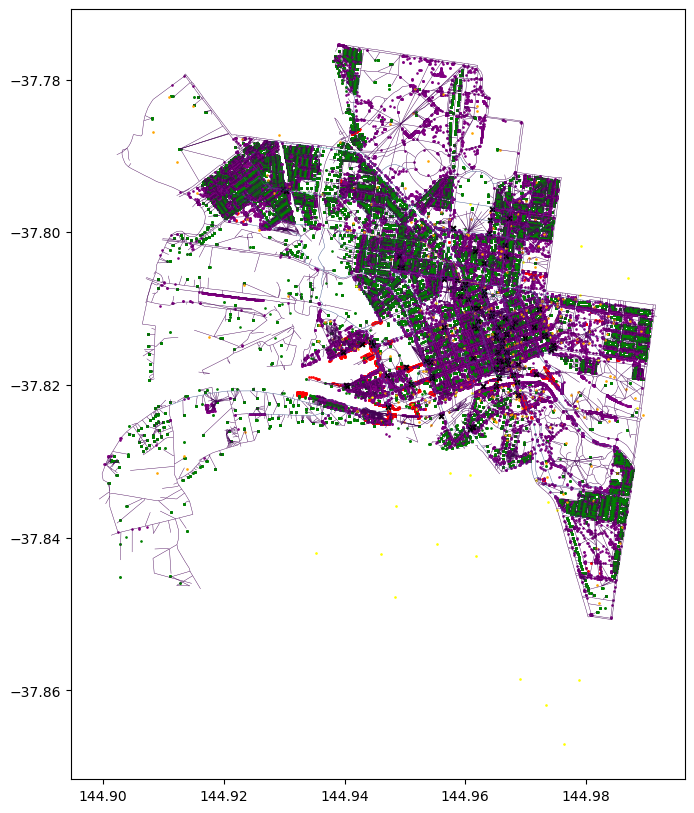

In [15]:
fig,ax=plt.subplots(figsize=(15,10))
lights_gdf.plot(ax=ax, marker='o', color='red', markersize=0.8,legend = True)
buildings_gdf.plot(ax=ax, marker='o', color='green', markersize=.8,legend = True)
furniture_gdf.plot(ax=ax, marker='o', color='purple', markersize=.8,legend = True)
bikes_gdf.plot(ax=ax, marker='o', color='yellow', markersize=.8,legend = True)
landmarks_gdf.plot(ax=ax, marker='o', color='orange', markersize=.8,legend = True)
sensors_gdf.plot(ax=ax, marker='x', color='black', markersize=12,legend = True)

gdf_edges.plot(ax=ax,column='betweenn_1', figsize =(10,10), scheme = 'EqualInterval', linewidth=0.3)

# Find number of each feature within the radius of each sensor

NB: If you use the full buildings_gdf with this method then it returns way too many buildings as each building is listed seperately in each year  
Can check this with:  
buildings_gdf[buildings_gdf.duplicated(['Longitude', 'Latitude'], keep=False)].sort_values(['Longitude', 'Latitude'])[0:12]

In [7]:
fp_to_save_to =  "../Cleaned_data/num_features_near_sensors_{}.csv".format(buffer_size_m)

In [76]:
# Create a dictionary containing all the feature gdfs, and their names
gdfs = {'bikes': bikes_gdf, 'lights':lights_gdf, 'furniture': furniture_gdf, 'landmarks':landmarks_gdf}

# Add a gdf containing just the buildings present in each year to the dictionary of gdfs
for year in sorted(buildings_gdf.year.unique()):
    this_year = buildings_gdf[buildings_gdf.year == year].copy()
    this_year.reset_index(inplace=True, drop = True)
    gdfs["buildings_{}".format(year)] = this_year  

# Create a list of the sub column names for each GDF
gdf_subtheme_column_name = [ 'capacity', "lamp_rating_w", 'feature', 'theme']
for year in buildings_gdf.year.unique():
    gdf_subtheme_column_name.append('building_use')

In [192]:
# For counting the number of features:
# Keys will be sensor numbers, items will be list of number of each type of feature in this sensor's radius
num_features = {}
# Keys will be sensor numbers, items will be a dataframe containing location and type of features in sensor radius
feature_details = {}
# Dataframe to store the average number of floors in the buildings present in each year, in radius of each sensor
building_floors_df = pd.DataFrame()

# Loop through each sensor
for sensor_num in sorted(sensors_gdf['sensor_id'].unique().tolist()):
    # Dataframe to contain location and feature types from all gdfs, for this sensor 
    features_df_this_sensor = pd.DataFrame(None)
    # Lists to store the data for each sensor
    n_features_this_sensor = []
    buildings_avg_n_floors_this_sensor = []
    building_years = []

    # loop through each geodataframe
    for count, key in enumerate(gdfs.keys()):
        # Find the features from this geodataframe in the radius of this sensor
        features_this_sensor = find_features_near_sensor(sensor_num, gdfs[key], buffer_size_m, gdf_subtheme_column_name[count])

        # Create dataframe with the location and type of feature for this geodataframe nr the sensor
        features_df_this_gdf= pd.DataFrame({'Location': features_this_sensor[0], 'Type': key, 
                                                 'Subtype': features_this_sensor[1],
                                           'N_floors': features_this_sensor[2]})
        
        # If we are looking at building data, then find the avg number of floors for this year of building data
        # Add to the list of values
        if 'buildings' in key:
            buildings_avg_n_floors_this_sensor.append(features_df_this_gdf['N_floors'].mean())
            building_years.append(key.split('_')[1])

        # Add to dataframe containing results from all geodataframes
        features_df_this_sensor = pd.concat([features_df_this_sensor,features_df_this_gdf],axis=0)

        # Add the number of features of this type to the list
        n_features_this_sensor.append(len(features_df_this_gdf))

    # Add number/feature details to dictionaries
    num_features[sensor_num] = n_features_this_sensor
    feature_details[sensor_num] = features_df_this_sensor
    building_floors_df["{}".format(sensor_num)] = buildings_avg_n_floors_this_sensor

# Reformat
num_features = pd.DataFrame(num_features).T
num_features.columns =gdfs.keys()
num_features.reset_index(inplace=True)

# Add data on average number of floors for buildings in each year
building_floors_df.index =  ["avg_n_floors_{}".format(item) for item in building_years]
building_floors_df = building_floors_df.T
building_floors_df.reset_index(inplace = True, drop=True)

# Join datasets
num_features = num_features.join(building_floors_df)
num_features

# Add sensor Id as column
num_features['sensor_id'] = sorted(sensors_gdf['sensor_id'].unique().tolist())
# Save
# del num_features['index']
num_features.to_csv(fp_to_save_to, index = False)

In [203]:
num_features.to_csv(fp_to_save_to, index = False)

# Plot the features within the radius for one sensor

In [54]:
sensor_num = 5
this_sensor = buffered_sensors[buffered_sensors['sensor_id'] ==sensor_num].copy()

In [55]:
this_sensors_features = feature_details[sensor_num]
this_sensors_features['Longitude'] = this_sensors_features.Location.apply(lambda p: p.x)
this_sensors_features['Latitude'] = this_sensors_features.Location.apply(lambda p: p.y)
this_sensors_features.reset_index(inplace=True, drop = True)

# Plot
melbourne_map = folium.Map(location=[this_sensor.Latitude.mean(),
                           this_sensor.Longitude.mean()], zoom_start=18, control_scale=True)#, min_zoom = 13)
# Add sensor location marker
folium.Marker([this_sensor["Latitude"], this_sensor["Longitude"]], popup=this_sensor["sensor_id"], 
              icon = folium.Icon(color="red")).add_to(melbourne_map)

# # Add buffer zone
folium.GeoJson(data=this_sensor["polygon"]).add_to(melbourne_map)

# # Add features
for index in range(0, len(this_sensors_features)):
    feature = this_sensors_features[this_sensors_features.index ==index].copy()
    folium.CircleMarker([feature['Latitude'], feature['Longitude']], popup=feature["Type"],
        color = 'black', fill_color = 'white', fill = 'True', fill_opacity = True).add_to(melbourne_map)
       
melbourne_map

## Find number of subtypes of features in each sensor's radius

In [79]:
# Dataframe to contain location and feature types from all gdfs, for this sensor 
subtypes = pd.DataFrame(None)

for sensor_num in sorted(sensors_gdf['sensor_id'].unique().tolist()):
    this_sensors_features = feature_details[sensor_num]
    
    subtypes_this_sensor = pd.DataFrame(None)
    
    for key in ["bikes", "furniture", "landmarks","buildings_2010",'buildings_2011', "buildings_2012", "buildings_2013","buildings_2014",
                "buildings_2015", "buildings_2016","buildings_2017","buildings_2018", "buildings_2019", "buildings_2020"]:
        if key in this_sensors_features['Type'].unique() : 
            feature = this_sensors_features[this_sensors_features['Type'] == key]
            feature = feature.groupby('Subtype').agg({'Subtype': 'count'})
            feature = feature.rename(columns={"Subtype":sensor_num})
            feature.index = '{}_'.format(key) + feature.index.astype(str)
            
            subtypes_this_sensor = pd.concat([subtypes_this_sensor,feature],axis=0)
     
    # Add to dataframe containing results from all geodataframes
    subtypes = pd.concat([subtypes,subtypes_this_sensor],axis=1)

### Clean Data

In [80]:
subtypes = subtypes.T
subtypes.reset_index(inplace = True)
subtypes.rename(columns={'index':'sensor_id'}, inplace = True)
subtypes = subtypes.rename_axis(None, axis=1)

In [82]:
subtypes.to_csv("../Cleaned_data/feature_subtypes_near_sensors_{}_cleaned_buildings.csv".format(buffer_size_m),  index = False)